### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import corner
import random
import ultranest
from ultranest.plot import cornerplot

Optional mpi4py package is not installed.  MPI support is not available.


## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

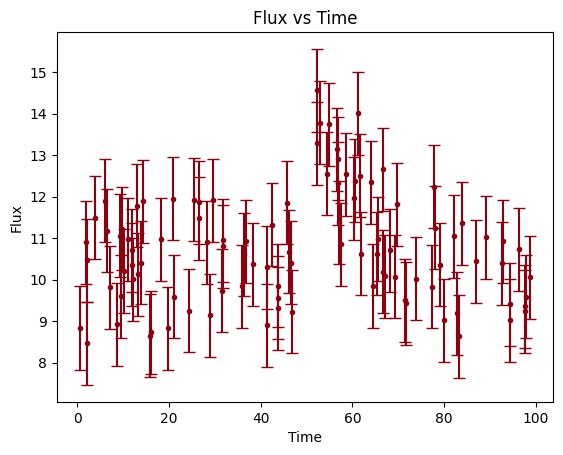

In [2]:
# SD: task 1
file = np.load("../../../homeworks/hw_data/hw5_data_1.npy") # SD: load in the file
time = file[:,0]
flux = file[:,1]
uncertainties = file[:,2]

plt.errorbar(time, flux, uncertainties, fmt=".", color="xkcd:crimson", capsize=4)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Flux vs Time")
plt.show()

In [3]:
# SD: task 2
def sharp_burst_model(theta, t):
    '''Function to code the sharp burst model.'''
    b, A, t_0, alpha = theta
    y_fit = []
    for time in t:
        if time < t_0:
            y_fit.append(b)
        else:
            y_fit.append(b + A*np.exp(-alpha*(time-t_0)))
    return y_fit

def logL(theta, data=[time, flux, uncertainties], model=sharp_burst_model):
    '''Log-likelihood calculator, defaults to the sharp burst model and the data we extracted at the start.'''
    t, y, sigma_y = data
    y_fit = model(theta, t)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

SRT: Good! Deducting one point due to for loop. Could be more compact and scalable with vectorization. -1 point

In [4]:
# SD: task 3
def Prior(x):
    '''Function to create the priors for b, A, t_0 and alpha for the sharp burst model.'''
    prior_b = stats.uniform.pdf(x[0], loc=0, scale=50)
    prior_A = stats.uniform.pdf(x[1], loc=0, scale=50)
    prior_t_0 = stats.uniform.pdf(x[2], loc=0, scale=100)
    prior_alpha = stats.uniform.pdf(np.log(x[3]), loc=-5, scale=10)
    return  prior_b * prior_A * prior_t_0 * prior_alpha

def logPrior(x):
    '''Function to return the log(Prior).'''
    return np.log(Prior(x))

# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logL, logPrior, cov, outDir='./my_ptmcmc_chain', resume=False)

In [5]:
# sampler for N steps
N = int(1e5) # SD: got this value by trial and error and increasing the values until I got the fuzzy catterpilar.
params = np.array([10.0, 5.0, 50, 0.1]) # SD: got these better initial guesses while test-running the code and seeing that the values seemed to settle here.
sampler.sample(params, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent in 0.000976 s Acceptance rate = 0

/tmp/ipykernel_248578/1055338212.py:7: RuntimeWarning: invalid value encountered in log
  prior_alpha = stats.uniform.pdf(np.log(x[3]), loc=-5, scale=10)


Finished 4.00 percent in 18.646126 s Acceptance rate = 0.655

/tmp/ipykernel_248578/1055338212.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(Prior(x))


Finished 10.00 percent in 46.894539 s Acceptance rate = 0.53083Adding DE jump with weight 50
Finished 100.00 percent in 452.586530 s Acceptance rate = 0.44568
Run Complete


Taking every n = 10 samples based on ac length.
Burning first n = 500 samples.


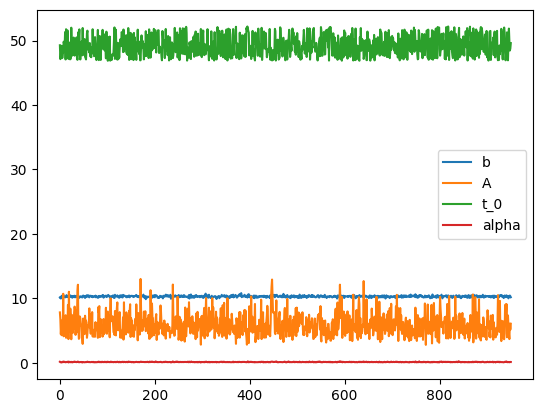

In [6]:
# SD: task 4
# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

import acor
thin = max([int(acor.acor(chain[:,i])[0]) for i in range(4)])
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(500) + ' samples.')

plt.plot(chain[500::thin,0], label="b")
plt.plot(chain[500::thin,1], label="A")
plt.plot(chain[500::thin,2], label="t_0")
plt.plot(chain[500::thin,3], label="alpha")
plt.legend()
plt.show()

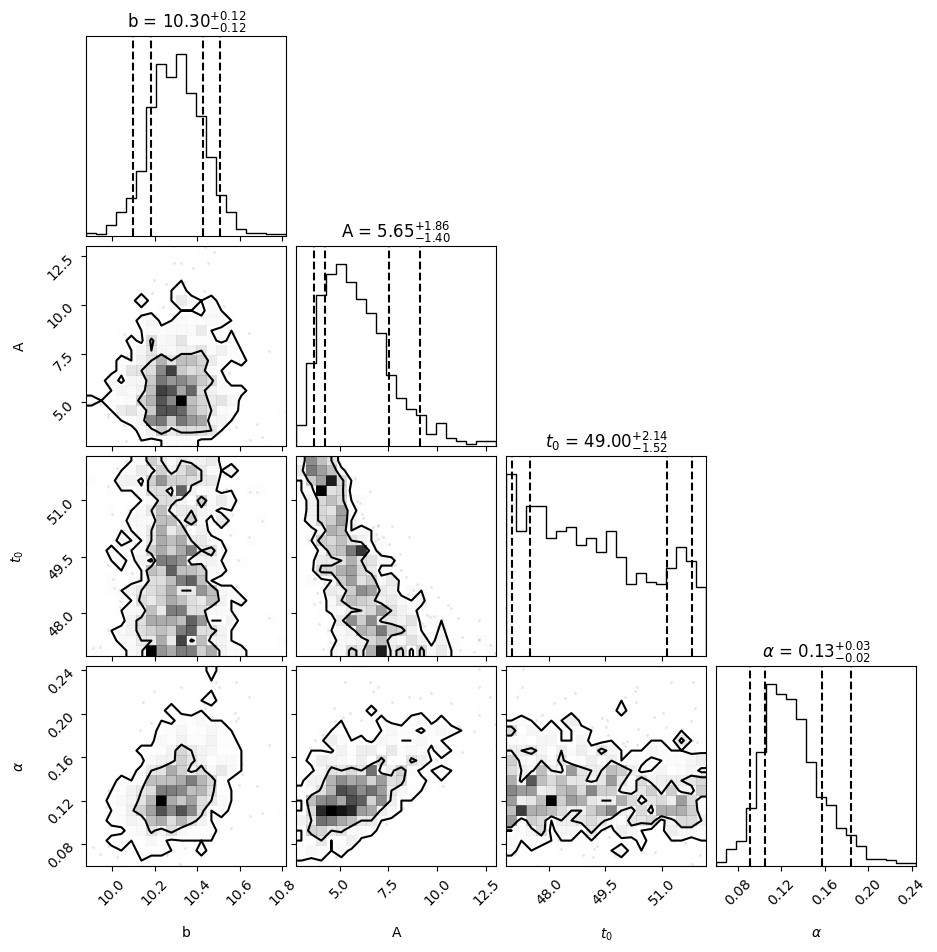

In [7]:
# SD: task 5
data = chain[500::thin,:4]
corner.corner(data, levels=(0.68, 0.95), title_quantiles=(0.16, 0.5, 0.84), quantiles=(0.05, 0.16, 0.84, 0.95), 
              show_titles=True, labels=["b", "A", r"$t_0$", r"$\alpha$"]) # SD: corner plot!
plt.show()

SRT: Excllent!

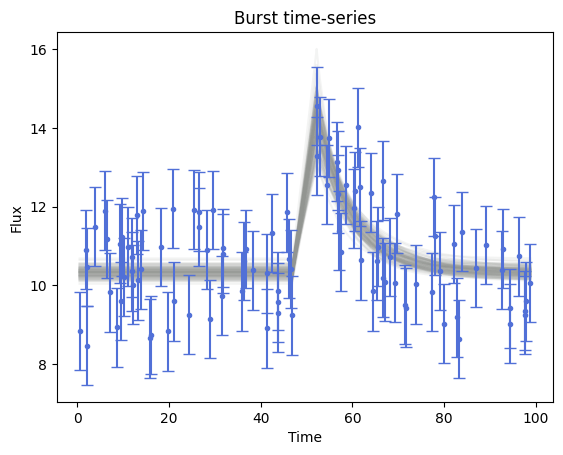

In [8]:
# SD: task 6
s = random.sample(list(data), 100)
for run in s:
    plt.plot(time, sharp_burst_model(run, time), "xkcd:grey", alpha=0.1)
plt.errorbar(time, flux, uncertainties, fmt=".", color="xkcd:cornflower blue", capsize=4) # SD: the model and the data points seem to match!
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Burst time-series")
plt.show()

SRT: Nice!

In [9]:
# SD: task 7
gaussian_param_names = ['b', 'A', 't_0', 'sigma']

def gaussian_priors(hypercube):
    '''Function to return the priors for the Gaussian model (w/ variables b, A, t_0 and sigma)'''
    params = hypercube.copy()

    lo = 0
    hi = 50
    params[0] = hypercube[0] * (hi - lo) + lo

    lo = 0
    hi = 50
    params[1] = hypercube[1] * (hi - lo) + lo

    lo = 0
    hi = 100
    params[2] = hypercube[2] * (hi - lo) + lo

    lo = -2
    hi = 2
    params[3] = np.exp(hypercube[3] * (hi - lo) + lo)

    return params

def gaussian_likelihood(params):
    '''Function to code the Gaussian model.'''
    b, A, t_0, sigma = params
    y_model = b + A*np.exp((-(time-t_0)**2) / (2*sigma**2))
    like = -0.5 * (((y_model - flux)/uncertainties)**2).sum()
    return like

In [10]:
gaussian_sampler = ultranest.ReactiveNestedSampler(gaussian_param_names, gaussian_likelihood, gaussian_priors)

In [11]:
gaussian_result = gaussian_sampler.run()
gaussian_sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-52.5648..-52.5647]*| it/evals=7920/53612 eff=14.8839% N=400        0 
[ultranest] Likelihood function evaluations: 53679
[ultranest]   logZ = -67.81 +- 0.1344
[ultranest] Effective samples strategy satisfied (ESS = 2109.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.

logZ = -67.786 +- 0.288
  single instance: logZ = -67.786 +- 0.182
  bootstrapped   : logZ = -67.806 +- 0.288
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.85  │ ▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▇▇▇▇▇▅▄▄▃▃▂▁▁▁▁▁▁▁   ▁ │10.87     10.32 +- 0.12
    A                   : 1.25  │ ▁  ▁▁▁▁▁▁▂▃▄▅▆▇▇▇▇▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁ │4.50      2.76 +- 0.38
    t_0                 : 51.5

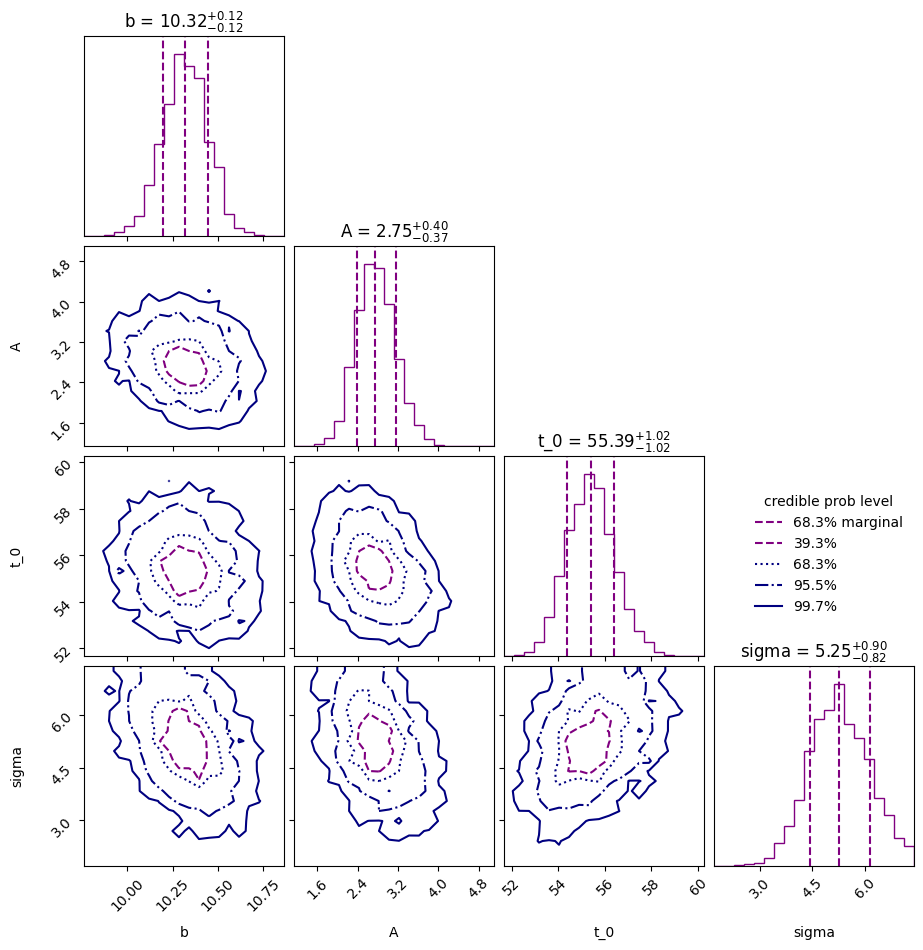

In [12]:
_ = cornerplot(gaussian_result)

In [13]:
burst_param_names = ['b', 'A', 't_0', 'alpha']

def burst_priors(hypercube):
    '''Function to return the priors for the sharp burst model (w/ variables b, A, t_0 and alpha)'''
    params = hypercube.copy()

    lo = 0
    hi = 50
    params[0] = hypercube[0] * (hi - lo) + lo

    lo = 0
    hi = 50
    params[1] = hypercube[1] * (hi - lo) + lo

    lo = 0
    hi = 100
    params[2] = hypercube[2] * (hi - lo) + lo

    lo = -5
    hi = 5
    params[3] = np.exp(hypercube[3] * (hi - lo) + lo)

    return params

def burst_likelihood(params):
    '''Function to code the sharp burst model.'''
    b, A, t_0, alpha = params
    y_model = []
    for t in time:
        if t < t_0:
            y_model.append(b)
        else:
            y_model.append(b + A*np.exp(-alpha*(t-t_0)))
    like = -0.5 * (((y_model - flux)/uncertainties)**2).sum()
    return like

SRT: Why not just use your brust likelihood from above? -1 point

In [14]:
burst_sampler = ultranest.ReactiveNestedSampler(burst_param_names, burst_likelihood, burst_priors)

In [15]:
burst_result = burst_sampler.run()
burst_sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-48.8098..-48.8098]*| it/evals=7650/73153 eff=10.5150% N=400       00 
[ultranest] Likelihood function evaluations: 73271
[ultranest]   logZ = -63.39 +- 0.1523
[ultranest] Effective samples strategy satisfied (ESS = 1886.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -63.366 +- 0.327
  single instance: logZ = -63.366 +- 0.181
  bootstrapped   : logZ = -63.388 +- 0.327
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.81  │ ▁▁▁▁▁▁▁▁▁▂▂▂▂▄▄▅▆▇▇▆▇▆▅▄▃▃▃▂▁▁▁▁▁▁▁▁▁ │10.76     10.30 +- 0.12
    A                   : 1.6   │ ▁▁▂▅▆▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁   ▁▁▁ ▁ │20.2      5.7 +- 1.7
    t_0                 : 46.6  

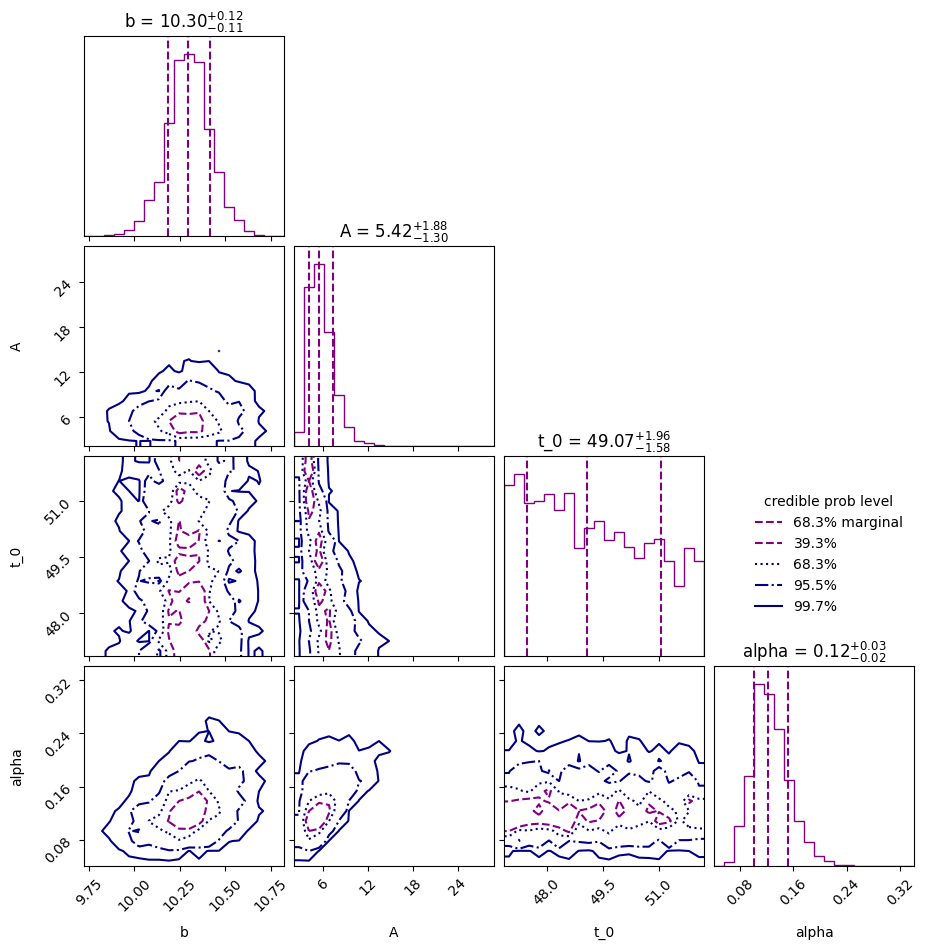

In [16]:
_ = cornerplot(burst_result)

In [17]:
print("Bayes Factor (Burst/Gaussian):", np.exp(burst_result["logz"])/np.exp(gaussian_result["logz"]))

Bayes Factor (Burst/Gaussian): 83.15292805354353


The sharp burst model is preferred over the gaussian model!

SRT: Excllent work! Different number than I got, but possibly due to fluctutions from using low numbers of live points (as I did too).

48/50